# Сборный проект - 2

## Описание и цель проекта

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом

Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 


Проект будет логически разделен на две задачи:
 - первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика
 - вторая — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.
 
Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.

In [1]:
!pip install phik -q
!pip install --upgrade scikit-learn -q
!pip install shap  -q

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import shap, phik

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder, 
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler, 
    RobustScaler,
    FunctionTransformer,
    LabelEncoder
)

from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.metrics import make_scorer, roc_auc_score

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC 

RANDOM_STATE = 42

In [2]:
plt.rcParams["figure.figsize"] = (10,5)
pd.set_option('display.max_rows', None)  # Отображать все строки
pd.set_option('display.max_columns', None)  # Отображать все столбцы

## Задача 1: предсказание уровня удовлетворённости сотрудника

### Загрузка данных

Загрузим файлы с данными:
 - тренировочная выборка: train_job_satisfaction_rate.csv
 - входные признаки тестовой выборки: test_features.csv
 - целевой признак тестовой выборки: test_target_job_satisfaction_rate.csv

In [3]:
train_job_satisfaction_rate = pd.read_csv('/datasets/train_job_satisfaction_rate.csv') #чтение файла /train_job_satisfaction_rate.csv  
display (train_job_satisfaction_rate.head()) #вывод первых пяти строк
print (train_job_satisfaction_rate.info()) #вывод общей информации о DataFrame


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB
None


Данные в таблице train_job_satisfaction_rate соответствуют описанию, в столбцах 'dept' и 'level' есть нулевые значения, что касается типа данных, логично преобразовать зарплату из int в float.

In [4]:
test_features = pd.read_csv('/datasets/test_features.csv') #чтение файла /test_features.csv  
display (test_features.head()) #вывод первых пяти строк
print (test_features.info()) #вывод общей информации о DataFrame


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB
None


Аналогично: данные в таблице test_features соответствуют описанию, в столбцах 'dept' и 'level' есть нулевые значения, что касается типа данных, логично преобразовать зарплату из int в float.

In [5]:
test_target_job_satisfaction_rate = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv') #чтение файла /test_features.csv  
display (test_target_job_satisfaction_rate.head()) #вывод первых пяти строк
print (test_target_job_satisfaction_rate.info()) #вывод общей информации о DataFrame


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB
None


Данные в таблице test_target_job_satisfaction_rate соответствуют описанию, нулевых значений нет, типы данных верные, количество строк совпадает с количеством строк в таблице test_features.

#### Промежуточный вывод
На данном этапе мы лишь загрузили данные и "познакомились" с ними - данные в таблице соответствуют описанию, в двух таблицах встречаются нулевые значения. Проведем предобработку данных.

### Предобработка данных

Переименование столбцов не требуется, проверим наличие дубликатов.

In [6]:
print('Количество дубликатов в таблице train_job_satisfaction_rate:', train_job_satisfaction_rate.duplicated().sum())
print('Количество дубликатов в таблице test_features:', test_features.duplicated().sum())
print('Количество дубликатов в таблице test_target_job_satisfaction_rate:', test_target_job_satisfaction_rate.duplicated().sum())


Количество дубликатов в таблице train_job_satisfaction_rate: 0
Количество дубликатов в таблице test_features: 0
Количество дубликатов в таблице test_target_job_satisfaction_rate: 0


Явных дубликатов нет, попробуем выявить неявные дубликаты. Для этого:

 - проверим число уникальных id в таблицах
 - выведем уникальные значения категориальных признаков в таблицах, если уникальных значений немного, можно проверить на наличие опечаток

In [7]:
print ('Количество id в таблице train_job_satisfaction_rate:', train_job_satisfaction_rate['id'].nunique())
print ('Значения столбца dept в таблице train_job_satisfaction_rate:', train_job_satisfaction_rate['dept'].unique())
print ('Значения столбца level в таблице train_job_satisfaction_rate:', train_job_satisfaction_rate['level'].unique())
print ('Значения столбца workload в таблице train_job_satisfaction_rate:', train_job_satisfaction_rate['workload'].unique())
print ('Значения столбца last_year_promo в таблице train_job_satisfaction_rate:', train_job_satisfaction_rate['last_year_promo'].unique())
print ('Значения столбца last_year_violations в таблице train_job_satisfaction_rate:', train_job_satisfaction_rate['last_year_violations'].unique())
train_job_satisfaction_rate.info()


Количество id в таблице train_job_satisfaction_rate: 4000
Значения столбца dept в таблице train_job_satisfaction_rate: ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
Значения столбца level в таблице train_job_satisfaction_rate: ['junior' 'middle' 'sinior' nan]
Значения столбца workload в таблице train_job_satisfaction_rate: ['medium' 'high' 'low']
Значения столбца last_year_promo в таблице train_job_satisfaction_rate: ['no' 'yes']
Значения столбца last_year_violations в таблице train_job_satisfaction_rate: ['no' 'yes']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   in

исправим сразу опечатку sinior -> senior

In [8]:
train_job_satisfaction_rate['level'] = train_job_satisfaction_rate['level'].replace('sinior', 'senior')
print ('Значения столбца level в таблице train_job_satisfaction_rate:', train_job_satisfaction_rate['level'].unique())


Значения столбца level в таблице train_job_satisfaction_rate: ['junior' 'middle' 'senior' nan]


In [9]:
print ('Количество id в таблице test_features:', test_features['id'].nunique())
print ('Значения столбца dept в таблице test_features:', test_features['dept'].unique())
print ('Значения столбца level в таблице test_features:', test_features['level'].unique())
print ('Значения столбца workload в таблице test_features:', test_features['workload'].unique())
print ('Значения столбца last_year_promo в таблице test_features:', test_features['last_year_promo'].unique())
print ('Значения столбца last_year_violations в таблице test_features:', test_features['last_year_violations'].unique())
test_features.info()


Количество id в таблице test_features: 2000
Значения столбца dept в таблице test_features: ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
Значения столбца level в таблице test_features: ['junior' 'middle' 'sinior' nan]
Значения столбца workload в таблице test_features: ['medium' 'low' 'high' ' ']
Значения столбца last_year_promo в таблице test_features: ['no' 'yes']
Значения столбца last_year_violations в таблице test_features: ['no' 'yes']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations  

исправим сразу опечатку sinior -> senior

In [10]:
test_features['level'] = test_features['level'].replace('sinior', 'senior')
print ('Значения столбца level в таблице test_features:', test_features['level'].unique())


Значения столбца level в таблице test_features: ['junior' 'middle' 'senior' nan]


In [11]:
print ('Количество id в таблице test_target_job_satisfaction_rate:', test_target_job_satisfaction_rate['id'].nunique())
test_target_job_satisfaction_rate.info()


Количество id в таблице test_target_job_satisfaction_rate: 2000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


Неявных дубликатов тоже нет, но есть нулевые и пустые значения, исследуем их (обработка будет в пайалайне).

In [12]:
missing_values = train_job_satisfaction_rate[train_job_satisfaction_rate.isnull().any(axis=1) | (train_job_satisfaction_rate == ' ').any(axis=1)]
display(missing_values)


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,NaN,medium,1,no,no,4,27600,0.66
1469,416327,sales,NaN,low,1,no,no,5,18000,0.73
1526,694746,NaN,junior,medium,5,no,no,4,21600,0.62
1630,814624,NaN,junior,medium,3,no,no,4,24000,0.88
1633,475114,NaN,junior,high,4,no,no,4,31200,0.63
1745,135043,sales,NaN,medium,1,no,no,3,26400,0.30
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.71
2781,497243,NaN,junior,medium,1,no,no,3,26400,0.28
2975,168668,NaN,junior,low,3,no,no,4,18000,0.88
3866,641150,NaN,junior,low,3,no,yes,4,12000,0.54


Разберем сначала строки, где level = NaN.
Все эти сотрудники работают в отделе продаж. Логично предположить, что надо изучить столбец salary.

In [13]:
display (train_job_satisfaction_rate[train_job_satisfaction_rate['workload'] == 'low'].sort_values(by='salary'))


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
2,184592,sales,junior,low,1,no,no,2,12000,0.11
2361,507549,sales,junior,low,1,no,no,4,12000,0.43
3493,440121,sales,junior,low,1,no,no,3,12000,0.18
2335,374761,sales,junior,low,1,no,no,5,12000,0.58
2319,246584,sales,junior,low,1,no,no,2,12000,0.10
324,504426,sales,junior,low,2,no,no,4,12000,0.60
3514,824311,sales,junior,low,2,no,no,1,12000,0.30
2238,433341,sales,junior,low,2,no,no,3,12000,0.33
3547,434165,sales,junior,low,1,no,no,1,12000,0.22
3548,199729,sales,junior,low,1,no,no,3,12000,0.24


Из таблицы выше видим, что:
 - зарплату в 27600 имеют сотрудники 'junior+medium' или 'middle+low', соответственно у сотрудников с id 631073	и 998838 пропуски в столбце level можно заполнить значением junior
  - зарплату в 26400 имеют сотрудники 'junior+medium' или 'senior+low', соответственно у сотрудников с id 135043 пропуски в столбце level можно заполнить значением junior
   - зарплату в 18000 имеют сотрудники 'junior+low' или 'middle+low', соответственно у сотрудника с id 416327 пропуск в столбце level нельзя заполнить однозначно, предлагаю удалить строку

Теперь разберем строки, где dept = NaN.
Аналогично изучим столбец salary в сочетании с workload и level.

In [14]:
display (train_job_satisfaction_rate[train_job_satisfaction_rate['level'] == 'junior'].sort_values(by='salary'))


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
2231,613980,purchasing,junior,low,1,no,no,2,12000,0.16
1548,229444,purchasing,junior,low,1,no,yes,3,12000,0.06
256,876633,sales,junior,low,1,no,no,3,12000,0.10
3304,501458,sales,junior,low,3,no,no,5,12000,0.68
3653,466452,sales,junior,low,4,no,yes,4,12000,0.58
3005,425069,sales,junior,low,1,no,no,4,12000,0.58
666,259397,sales,junior,low,2,no,no,5,12000,0.74
278,716287,sales,junior,low,1,no,no,2,12000,0.23
243,781702,purchasing,junior,low,1,no,no,3,12000,0.19
280,228333,purchasing,junior,low,1,no,no,1,12000,0.24


Рассуждая аналогичным образом, получаем, что нельзя однозначно определить отдел сотрудника, предлагается удалить полученные 6 строк (в сравнении с общей выборкой, процент удаляемых строк мал).

Теперь посмотрим на пустые и нулевые значения таблицы test_features (будем рассуждать аналогично).
Для удобства дальнейшей обработки заменим пропуски (' ') на NaN.

In [15]:
test_features.replace(' ', np.nan, inplace=True)
missing_values = test_features[test_features.isnull().any(axis=1) | (test_features == ' ').any(axis=1)]
display(missing_values)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
15,590867,marketing,junior,NaN,4,no,no,4,28800
191,609865,NaN,junior,medium,1,no,no,1,20400
312,471990,sales,NaN,low,1,no,no,3,12000
1196,832342,NaN,junior,medium,1,no,no,4,28800
1699,822186,NaN,middle,medium,3,no,no,4,38400


In [16]:
display (test_features[test_features['dept'] == 'sales'].sort_values(by='salary'))


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
196,385357,sales,junior,low,1,no,yes,2,12000
117,493196,sales,junior,low,1,no,no,4,12000
1114,417411,sales,junior,low,2,no,no,4,12000
1109,630899,sales,junior,low,2,no,no,4,12000
1100,647748,sales,junior,low,1,no,no,4,12000
1091,886676,sales,junior,low,1,no,no,2,12000
1089,753099,sales,junior,low,2,no,no,4,12000
1076,944719,sales,junior,low,1,no,no,3,12000
1539,948721,sales,junior,low,1,no,no,4,12000
1760,469246,sales,junior,low,2,no,no,5,12000


Для сотрудника с id = 471990 заполним столбец level значением junior.
С пустыми значениями в столбце 'dept' (id = 609865, 832342, 822186) - нельзя точно определить отдел, соотвестственно, удаляем эти строки (их всего 3 из 2000). ~~Сразу исключим удаленных пользователей и из файла test_target_job_satisfaction_rate.


In [17]:
#test_features.loc[test_features['id'].isin([471990]), 'level'] = 'junior'
#test_features = test_features[~test_features['id'].isin([609865, 832342, 822186])]
#test_target_job_satisfaction_rate = test_target_job_satisfaction_rate[~test_target_job_satisfaction_rate['id'].isin([609865, 832342, 822186])]

#missing_values = test_features[test_features.isnull().any(axis=1) | (test_features == ' ').any(axis=1)]
#display(missing_values.sort_values(by='salary'))

In [18]:
display (test_features[test_features['dept'] == 'marketing'].sort_values(by='salary'))


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1133,696192,marketing,junior,low,2,no,no,4,13200
230,400608,marketing,junior,low,2,no,yes,3,13200
830,582749,marketing,junior,low,1,no,no,3,13200
343,208164,marketing,junior,low,1,no,no,4,13200
947,853603,marketing,junior,low,1,no,no,3,13200
162,484623,marketing,junior,low,5,no,no,3,13200
1214,841740,marketing,junior,low,1,no,no,1,13200
89,358227,marketing,junior,low,2,no,no,3,13200
205,508688,marketing,junior,low,1,no,no,3,16800
322,735782,marketing,junior,low,2,no,no,4,16800


~~В отделе маркетинга зарплату в 28800 получают сотрудники с level = junior и workload = medium, заполним пустое значение значением medium.~~

In [19]:
#test_features.loc[test_features['id'].isin([590867]), 'workload'] = 'medium'
#test_features.info()

Заменим формат данных столбца salary на float.

In [20]:
train_job_satisfaction_rate['salary'] = train_job_satisfaction_rate['salary'].astype('float64')
test_features['salary'] = test_features['salary'].astype('float64')
display (train_job_satisfaction_rate.info())
test_features.info()
test_target_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   float64
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(2), int64(3), object(5)
memory usage: 312.6+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   dept                   1997 non-null   object 
 2   level                  1999 non-null   object 
 3   workload               1999 non-null   object 
 4   employment_years       2000 non-null   int64  
 5   last_year_promo        2000 non-null   object 
 6   last_year_violations   2000 non-null   object 
 7   supervisor_evaluation  2000 non-null   int64  
 8   salary                 2000 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 140.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int6

#### Промежуточный вывод
На данном этапе выполнена предобработка даных:
 - проверены значения на наличие дубикатов
 - проанализированы пропуски (для дальнейшей обработки в пайплайне)
 - изменен формат данных

### Исследовательский анализ данных

#### Анализ данных в таблице train_job_satisfaction_rate
Построим графики для каждого признака и матрицу корреляции признаков. 
Выведем для удобства числовое описание диаграммы размаха (добавив в таблицу границы нормальных значений).

In [21]:
info_train_job_satisfaction_rate = train_job_satisfaction_rate.drop(columns=['id']).describe().T
info_train_job_satisfaction_rate['norm_min']=info_train_job_satisfaction_rate['25%']-1.5*info_train_job_satisfaction_rate['std']
info_train_job_satisfaction_rate['norm_max']=info_train_job_satisfaction_rate['75%']+1.5*info_train_job_satisfaction_rate['std']
info_train_job_satisfaction_rate


,count,mean,std,min,25%,50%,75%,max,norm_min,norm_max
employment_years,4000.0,3.718500,2.542513,1.00,2.00,3.00,6.00,10.0,-1.813770,9.813770
supervisor_evaluation,4000.0,3.476500,1.008812,1.00,3.00,4.00,4.00,5.0,1.486782,5.513218
salary,4000.0,33926.700000,14900.703838,12000.00,22800.00,30000.00,43200.00,98400.0,448.944244,65551.055756
job_satisfaction_rate,4000.0,0.533995,0.225327,0.03,0.36,0.56,0.71,1.0,0.022009,1.047991


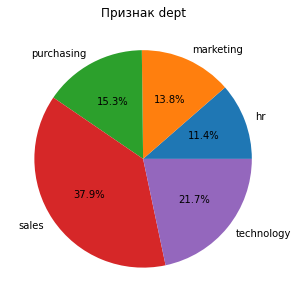

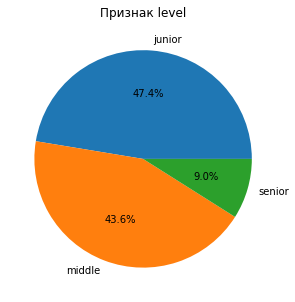

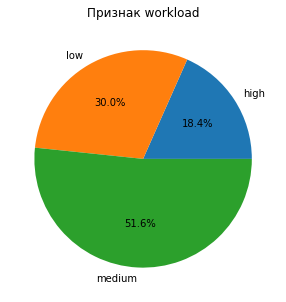

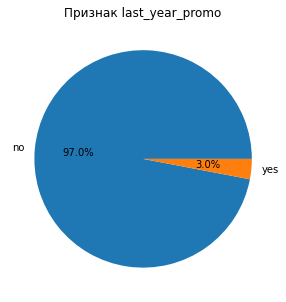

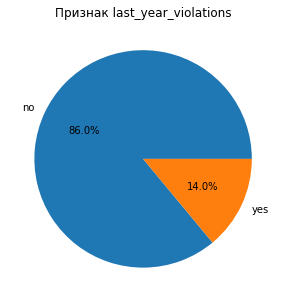

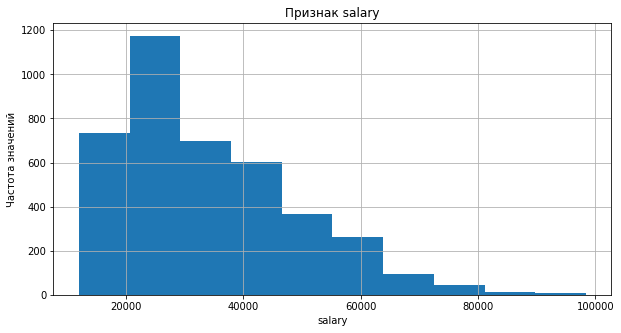

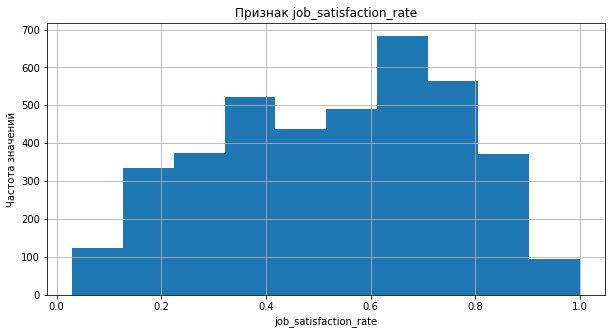

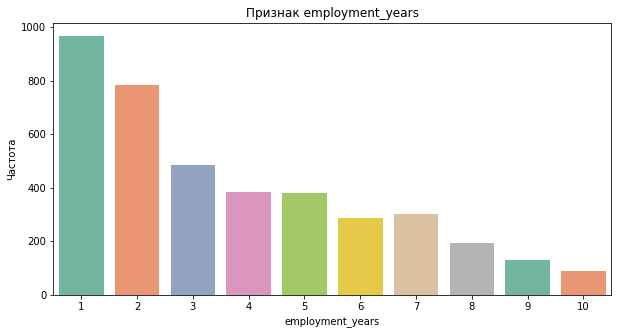

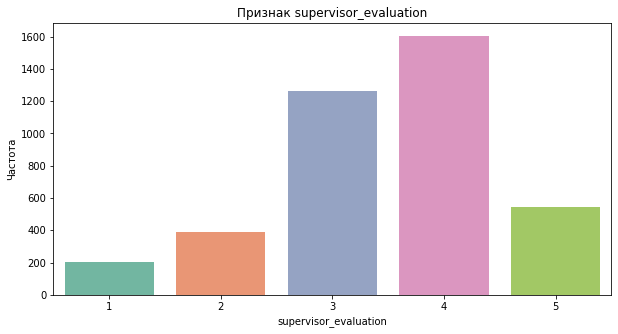

In [22]:
# определяем категориальные и количественные признаки
categorical_features = train_job_satisfaction_rate.select_dtypes(include=['object']).columns
numerical_features = ['salary', 'job_satisfaction_rate']
discrete_features = ['employment_years', 'supervisor_evaluation']

# построение графиков для категориальных признаков
for i, feature in enumerate(categorical_features):
    train_job_satisfaction_rate.groupby(feature)[feature].count().plot.pie(autopct='%1.1f%%')
    plt.title(f'Признак {feature}')
    plt.ylabel('')
    plt.show() 

# построение графиков для количественных признаков
for i, feature in enumerate(numerical_features):
    pd.Series(train_job_satisfaction_rate[feature]).hist()
    plt.title(f'Признак {feature}')
    plt.xlabel(feature)
    plt.ylabel('Частота значений')
    plt.show()  

# Построение графиков для дискретных признаков
for feature in discrete_features:
    sns.countplot(data=train_job_satisfaction_rate, x=feature, palette="Set2")
    plt.title(f'Признак {feature}')
    plt.xlabel(feature)
    plt.ylabel('Частота')
    plt.show()


Судя по графикам, выбросов не зафиксировано, в целом, картина "адекватная" - только очень мало повышений за последний год :)

Рассчитаем коэффициенты корреляции Фи (так как нужно отобразить взаимосвязь между категориальными и интервальными признаками, а корреляция Пирсона не подходит для категориальных признаков).

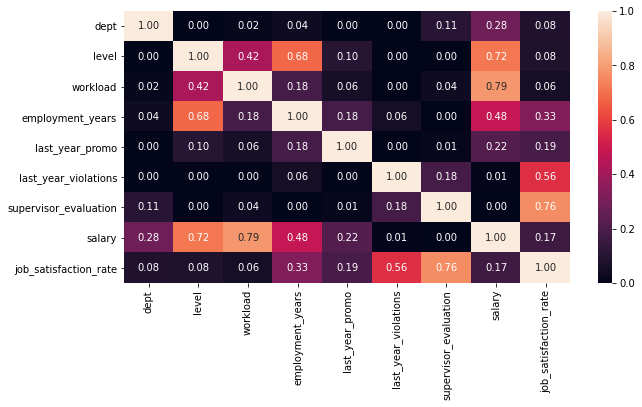

In [23]:
sns.heatmap(train_job_satisfaction_rate.drop(columns=['id']).phik_matrix(interval_cols=['salary', 'job_satisfaction_rate']), annot=True, fmt='.2f')
plt.show()

Можем отметить высокую зависимость:
 - между загруженностью и зарплатой (логично, но недостаточно для удаления одного из признаков)
 - между удовлетворенностью сотрудника и его оценкой руководителем (тоже можно уловить взаимосвязь, но признак удалять не будем)

Посмотрим на графики распределения признаков в разрезе целевого признака (количество проработанных лет и оценку руководителем на этапе анализа отнесем к категориальным данным, так как это целые числа с опеределенным диапазоном, легче будет видуализировать по категориям).

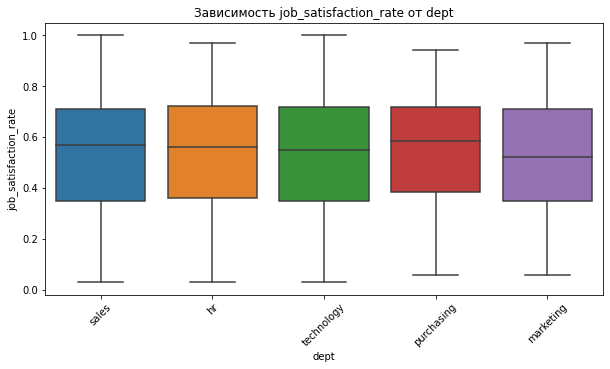

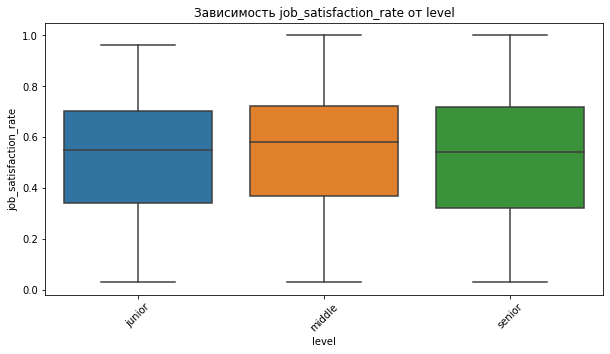

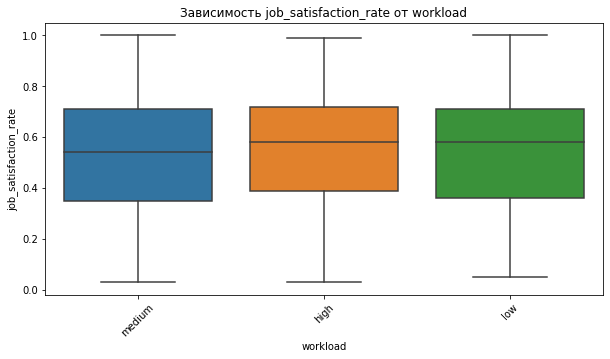

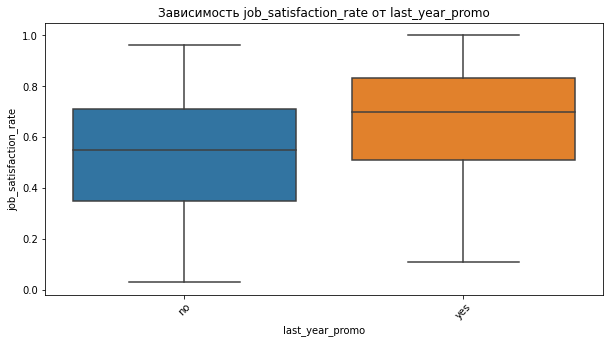

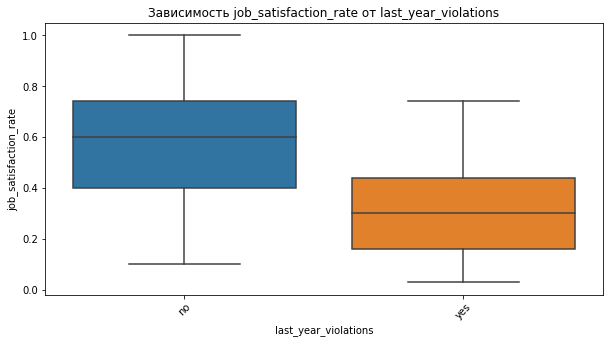

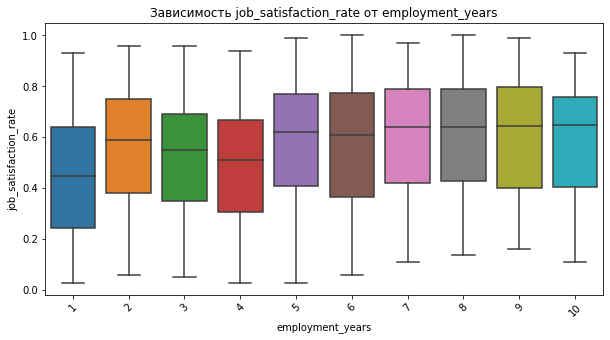

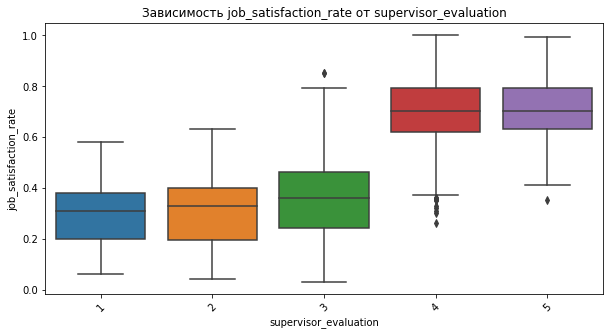

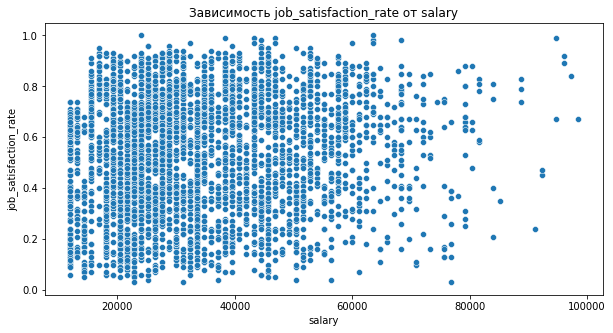

In [24]:
# определяем количественные и категориальные признаки
categorical_features = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations', 'employment_years', 'supervisor_evaluation']
numerical_features = ['salary']

# графики для категориальных признаков
for col in categorical_features:
    sns.boxplot(x=col, y='job_satisfaction_rate', data=train_job_satisfaction_rate)
    plt.title(f'Зависимость job_satisfaction_rate от {col}')
    plt.xticks(rotation=45)
    plt.show()

# графики для числовых признаков
for col in numerical_features:
    sns.scatterplot(x=col, y='job_satisfaction_rate', data=train_job_satisfaction_rate)
    plt.title(f'Зависимость job_satisfaction_rate от {col}')
    plt.show()
    

#### Промежуточный вывод
 - удовлетворенность сотрудников примерно одинаково распределена по отделам (можно предположить, что везде работают вполне компетентные и адекватные руководители :))
 - также удовлетворенность сотрудников равнораспределена по уровням и загруженности
 - а вот от факта повышения или нарушений наблюдается зависимость (уровень удовлетворенности выше при наличии повышения и отсутствии нарушений)
 - сотрудники, которые работают более 4 лет, примерно одинаково распределен уровень удовлетворенности, у "новичков" он ниже
 - также видим, что чем выше руководитель оценивает сотрудника, тем выше его удовлетворенность (видимо, тем лучше отношение руководителя к нему)
 - зарплата, в целом, не является определяющим фактором, то есть можем предположить, что она соответствует выполняемым сотрудником обязанностей

Проведем аналогичный анализ на тестовой выборке.

In [25]:
info_test_features = test_features.drop(columns=['id']).describe().T
info_test_features['norm_min']=info_test_features['25%']-1.5*info_test_features['std']
info_test_features['norm_max']=info_test_features['75%']+1.5*info_test_features['std']
info_test_features

,count,mean,std,min,25%,50%,75%,max,norm_min,norm_max
employment_years,2000.0,3.6665,2.537222,1.0,1.0,3.0,6.0,10.0,-2.805833,9.805833
supervisor_evaluation,2000.0,3.5265,0.996892,1.0,3.0,4.0,4.0,5.0,1.504661,5.495339
salary,2000.0,34066.8000,15398.436729,12000.0,22800.0,30000.0,43200.0,96000.0,-297.655093,66297.655093


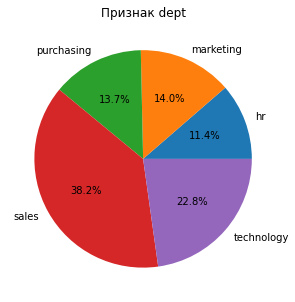

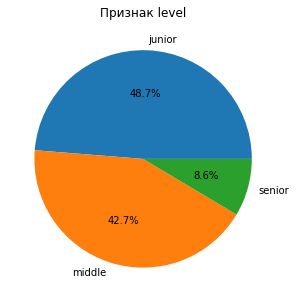

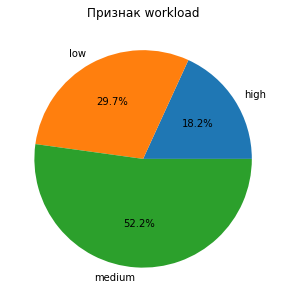

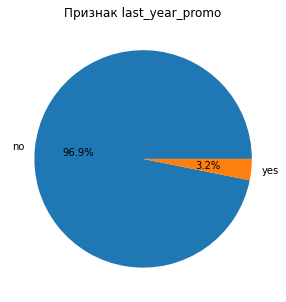

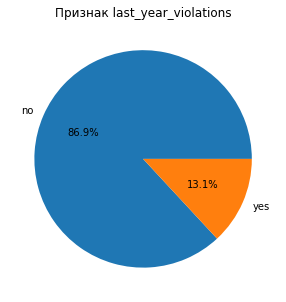

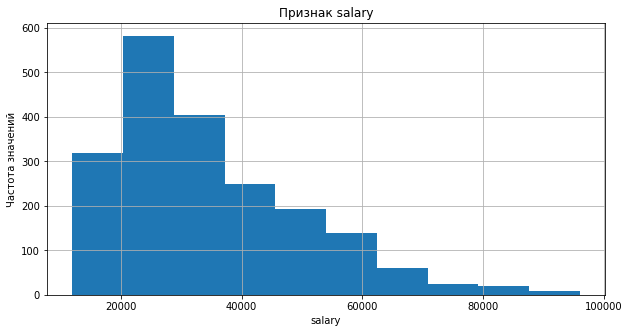

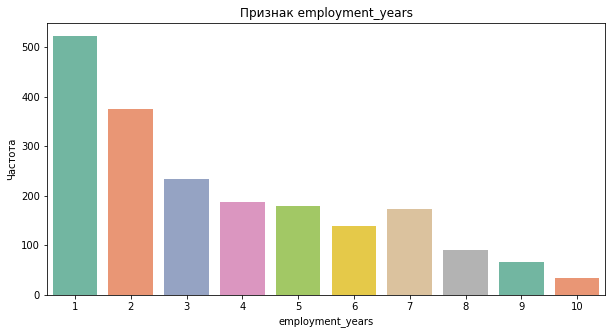

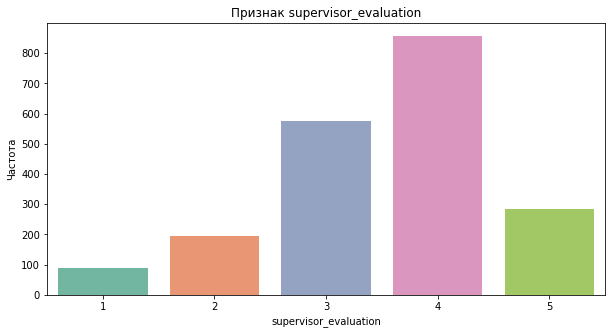

In [26]:
# определяем категориальные и количественные признаки
categorical_features = test_features.select_dtypes(include=['object']).columns
numerical_features = ['salary']
discrete_features = ['employment_years', 'supervisor_evaluation']

# построение графиков для категориальных признаков
for i, feature in enumerate(categorical_features):
    test_features.groupby(feature)[feature].count().plot.pie(autopct='%1.1f%%')
    plt.title(f'Признак {feature}')
    plt.ylabel('')
    plt.show() 

# построение графиков для количественных признаков
for i, feature in enumerate(numerical_features):
    pd.Series(test_features[feature]).hist()
    plt.title(f'Признак {feature}')
    plt.xlabel(feature)
    plt.ylabel('Частота значений')
    plt.show()  

# Построение графиков для дискретных признаков
for feature in discrete_features:
    sns.countplot(data=test_features, x=feature, palette="Set2")
    plt.title(f'Признак {feature}')
    plt.xlabel(feature)
    plt.ylabel('Частота')
    plt.show()


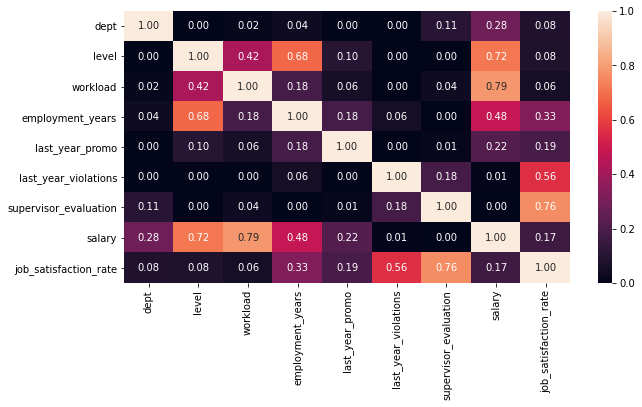

In [27]:
sns.heatmap(train_job_satisfaction_rate.drop(columns=['id']).phik_matrix(interval_cols=['salary', 'job_satisfaction_rate']), annot=True, fmt='.2f')
plt.show()

При просмотре графиков в части тестовых данных наблюдаются тенденции, аналогичные тренировочной выборке.

### Подготовка данных

Выполним подготовку признаков, дополнив пайплайн шагом предобработки.

In [28]:
train_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   float64
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(2), int64(3), object(5)
memory usage: 312.6+ KB


In [29]:
train_job_satisfaction_rate_without_id = train_job_satisfaction_rate.drop(['id'], axis=1)
print('Количество дубликатов в таблице train_job_satisfaction_rate_without_id:', train_job_satisfaction_rate_without_id.duplicated().sum())


Количество дубликатов в таблице train_job_satisfaction_rate_without_id: 245


Удалим дубликаты, появившиеся после удаления id.

In [30]:
train_job_satisfaction_rate_without_id=train_job_satisfaction_rate_without_id.drop_duplicates()

In [31]:
X_train = train_job_satisfaction_rate_without_id.drop(['job_satisfaction_rate'], axis=1)


In [32]:
merged_test = test_features.merge(test_target_job_satisfaction_rate, on='id', how='left')

In [33]:
y_train = train_job_satisfaction_rate_without_id['job_satisfaction_rate']
X_test = merged_test.drop(['id', 'job_satisfaction_rate'], axis=1)
y_test = merged_test['job_satisfaction_rate']


# создаём списки с названиями признаков
ohe_columns = ['last_year_promo', 'last_year_violations', 'dept']
ord_columns = ['level', 'workload']

In [34]:
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']

# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE

#ohe_pipe = Pipeline(
 #   [('knn_imputer', KNNImputer(n_neighbors=5)), 
  #   ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
   # ]
#)

ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ]
    )

ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'],
                    ['low', 'medium', 'high'],
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

#### Промежуточный вывод
На данном этапе мы лишь подготовили данные, перейдем к обучению и выбору модели.

### Обучение моделей

Обучим две модели. Возьмем одну линейную модель, а в качестве второй — дерево решений. Подберем гиперпараметры.
Выберем лучшую модель и проверим её качество. 
Выбор будем делать на основе новой метрики — SMAPE (англ. symmetric mean absolute percentage error, «симметричное среднее абсолютное процентное отклонение»). 
Для этого сначала напишем функцию, которая принимает на вход массивы NumPy или объекты Series в pandas и возвращает значение метрики SMAPE.

In [35]:
def smape(y_true, y_pred):
   
    # Преобразуем входные данные в массивы NumPy, если это необходимо
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    # Вычисляем SMAPE
    smape = np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred)) / 2)) * 100
    return smape

smape_scorer = make_scorer(smape, greater_is_better=False)

In [36]:
results = []
param_grid = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(3, 20),
        'models__max_features': range(3, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]  
    },

    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'models__fit_intercept': [True, False],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]  
    },
]


randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    n_iter=100,
    scoring=smape_scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    return_train_score=True
)

In [37]:
randomized_search.fit(X_train, y_train)

#отображаем работу со всеми моделями, которые пробовали
for params, mean_score in zip(randomized_search.cv_results_['params'], randomized_search.cv_results_['mean_test_score']):
    params_copy = params.copy()
    params_copy.pop('models', None)
    results.append({'Модель': params['models'], 'Параметры': params_copy, 'Средний SMAPE': -mean_score})

results_df = pd.DataFrame(results)
display(results_df)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке (при кроссвалидации):', -randomized_search.best_score_)

,Модель,Параметры,Средний SMAPE
0,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': StandardScaler(), 'model...",21.774237
1,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': StandardScaler(), 'model...",23.318369
2,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': StandardScaler(), 'model...",16.050320
3,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': MinMaxScaler(), 'models_...",16.100909
4,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': MinMaxScaler(), 'models_...",16.251374
5,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': MinMaxScaler(), 'models_...",16.527710
6,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': StandardScaler(), 'model...",16.760848
7,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': StandardScaler(), 'model...",16.229531
8,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': MinMaxScaler(), 'models_...",23.384820
9,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': MinMaxScaler(), 'models_...",19.087846


Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['last_year_promo',
                                                   'last_year_violations',
                                                   'dept']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImput

In [38]:
# проверяем работу модели на тестовой выборке
# рассчитаем прогноз на тестовых данных
y_test_pred = np.round(randomized_search.predict(X_test), 2)
print(f'Метрика smape_scorer на тестовой выборке: {smape(y_test, y_test_pred)}')


Метрика smape_scorer на тестовой выборке: 14.49039339610694


### Выводы к задаче 1
Получена модель DecisionTreeRegressor, применим ее в задаче 2.

## Задача 2: предсказание увольнения сотрудника из компании

Для этой задачи мы будем использовать те же входные признаки, что и в предыдущей задаче. Однако целевой признак отличается: это quit — увольнение сотрудника из компании.

### Загрузка данных

Загрузим файлы с данными:

 - тренировочная выборка: train_quit.csv
 - входные признаки тестовой выборки (те же, что и в прошлой задаче, соответственно, они уже предобработаны): test_features.csv
 - целевой признак тестовой выборки: test_target_quit.csv


In [39]:
train_quit = pd.read_csv('/datasets/train_quit.csv') #чтение файла /train_quit.csv  
display (train_quit.head()) #вывод первых пяти строк
print (train_quit.info()) #вывод общей информации о DataFrame


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB
None


In [40]:
test_target_quit = pd.read_csv('/datasets/test_target_quit.csv') #чтение файла /test_target_quit.csv  
display (test_target_quit.head()) #вывод первых пяти строк
print (test_target_quit.info()) #вывод общей информации о DataFrame


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB
None


#### Промежуточный вывод
Данные в таблицах соответствуют описанию, нулевых значений нет.

### Предобработка данных

Переименование столбцов не требуется, проверим наличие дубликатов.

In [41]:
print('Количество дубликатов в таблице train_quit:', train_quit.duplicated().sum())
print('Количество дубликатов в таблице test_target_quit:', test_target_quit.duplicated().sum())


Количество дубликатов в таблице train_quit: 0
Количество дубликатов в таблице test_target_quit: 0


Явных дубликатов нет, попробуем выявить неявные дубликаты. Для этого:

 - проверим число уникальных id в таблицах
 - выведем уникальные значения категориальных признаков в таблицах, если уникальных значений немного, можно проверить на наличие опечаток

In [42]:
print ('Количество id в таблице train_quit:', train_quit['id'].nunique())
print ('Значения столбца dept в таблице train_quit:', train_quit['dept'].unique())
print ('Значения столбца level в таблице train_quit:', train_quit['level'].unique())
print ('Значения столбца workload в таблице train_quit:', train_quit['workload'].unique())
print ('Значения столбца last_year_promo в таблице train_quit:', train_quit['last_year_promo'].unique())
print ('Значения столбца last_year_violations в таблице train_quit:', train_quit['last_year_violations'].unique())
print ('Значения столбца quit в таблице train_quit:', train_quit['quit'].unique())
print ('Значения столбца quit в таблице test_target_quit:', test_target_quit['quit'].unique())


Количество id в таблице train_quit: 4000
Значения столбца dept в таблице train_quit: ['sales' 'purchasing' 'marketing' 'technology' 'hr']
Значения столбца level в таблице train_quit: ['middle' 'junior' 'sinior']
Значения столбца workload в таблице train_quit: ['high' 'medium' 'low']
Значения столбца last_year_promo в таблице train_quit: ['no' 'yes']
Значения столбца last_year_violations в таблице train_quit: ['no' 'yes']
Значения столбца quit в таблице train_quit: ['no' 'yes']
Значения столбца quit в таблице test_target_quit: ['yes' 'no']


Исправим опечатку sinior -> senior

In [43]:
train_quit['level'] = train_quit['level'].replace('sinior', 'senior')
print ('Значения столбца level в таблице train_quit:', train_quit['level'].unique())


Значения столбца level в таблице train_quit: ['middle' 'junior' 'senior']


In [44]:
test_features['level'] = test_features['level'].replace('sinior', 'senior')
print ('Значения столбца level в таблице test_features:', test_features['level'].unique())


Значения столбца level в таблице test_features: ['junior' 'middle' 'senior' nan]


#### Промежуточный вывод
Данные не требуют предобработки, дубликатов не выявлено, пустые значения будут обработаны на этапе создания пайплайнов.

### Исследовательский анализ данных

#### Анализ данных в таблице train_quit
Построим графики для каждого признака и матрицу корреляции признаков. 
Выведем для удобства числовое описание диаграммы размаха (добавив в таблицу границы нормальных значений).

In [45]:
info_train_quit = train_quit.drop(columns=['id']).describe().T
info_train_quit['norm_min']=info_train_quit['25%']-1.5*info_train_quit['std']
info_train_quit['norm_max']=info_train_quit['75%']+1.5*info_train_quit['std']
info_train_quit

,count,mean,std,min,25%,50%,75%,max,norm_min,norm_max
employment_years,4000.0,3.70150,2.541852,1.0,2.0,3.0,6.0,10.0,-1.812778,9.812778
supervisor_evaluation,4000.0,3.47475,1.004049,1.0,3.0,4.0,4.0,5.0,1.493926,5.506074
salary,4000.0,33805.80000,15152.415163,12000.0,22800.0,30000.0,43200.0,96000.0,71.377255,65928.622745


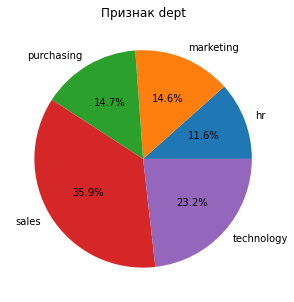

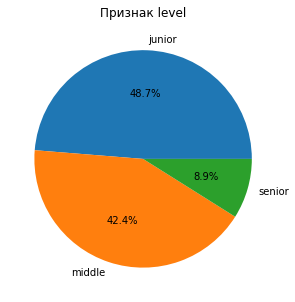

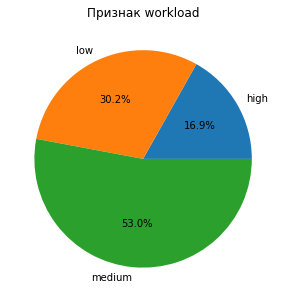

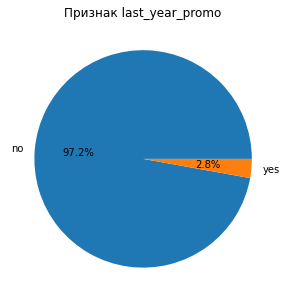

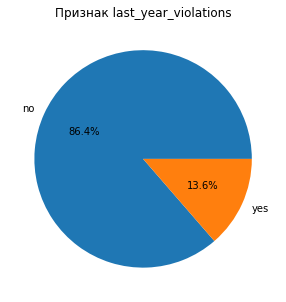

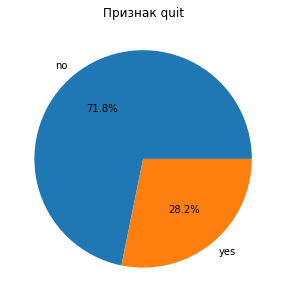

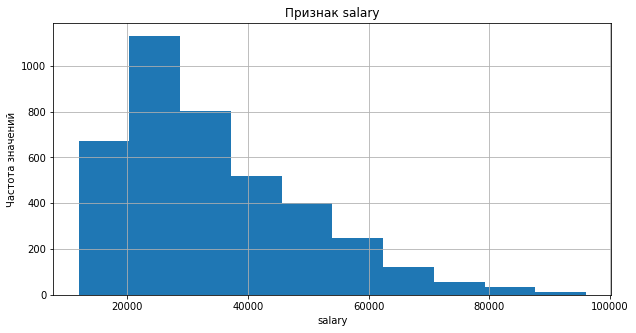

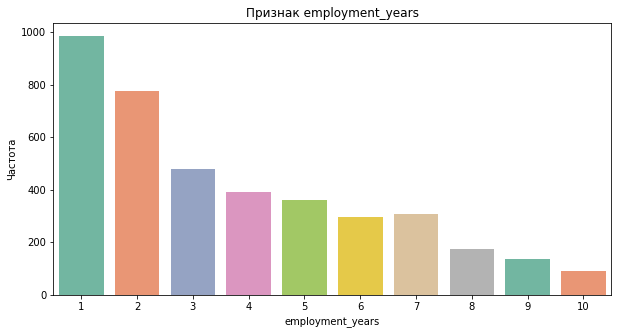

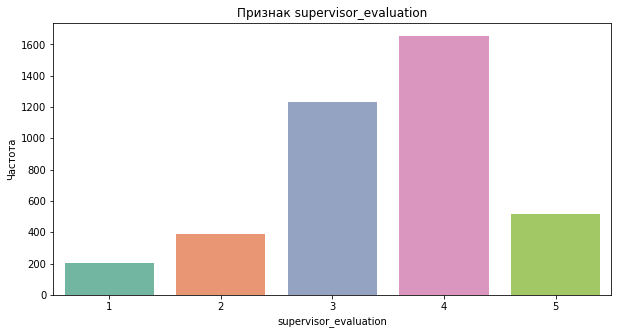

In [46]:
# определяем категориальные и количественные признаки
categorical_features = train_quit.select_dtypes(include=['object']).columns
numerical_features = ['salary']
discrete_features = ['employment_years', 'supervisor_evaluation']
    
# построение графиков для категориальных признаков
for i, feature in enumerate(categorical_features):
    train_quit.groupby(feature)[feature].count().plot.pie(autopct='%1.1f%%')
    plt.title(f'Признак {feature}')
    plt.ylabel('')
    plt.show() 

# построение графиков для количественных признаков
for i, feature in enumerate(numerical_features):
    pd.Series(train_quit[feature]).hist()
    plt.title(f'Признак {feature}')
    plt.xlabel(feature)
    plt.ylabel('Частота значений')
    plt.show()  

# Построение графиков для дискретных признаков
for feature in discrete_features:
    sns.countplot(data=train_quit, x=feature, palette="Set2")
    plt.title(f'Признак {feature}')
    plt.xlabel(feature)
    plt.ylabel('Частота')
    plt.show()


Судя по графикам, выбросов не зафиксировано. Рассчитаем коэффициенты корреляции Фи

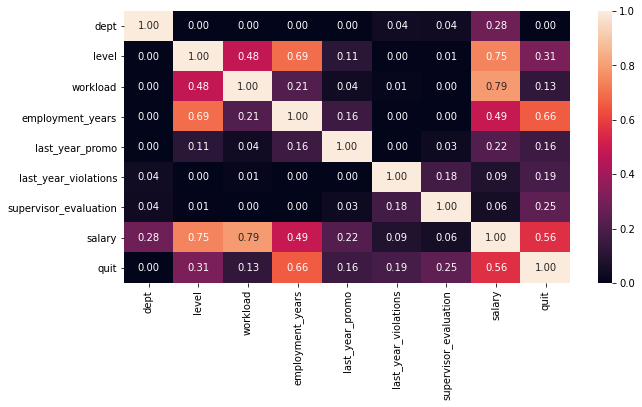

In [47]:
sns.heatmap(train_quit.drop(columns=['id']).phik_matrix(interval_cols=['salary']), annot=True, fmt='.2f')
plt.show()

Мультиколлинеарность признаков не зафиксирована.

Посмотрим на графики распределения признаков в разрезе целевого признака.

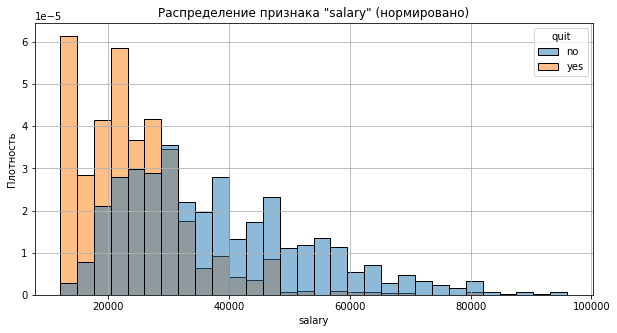

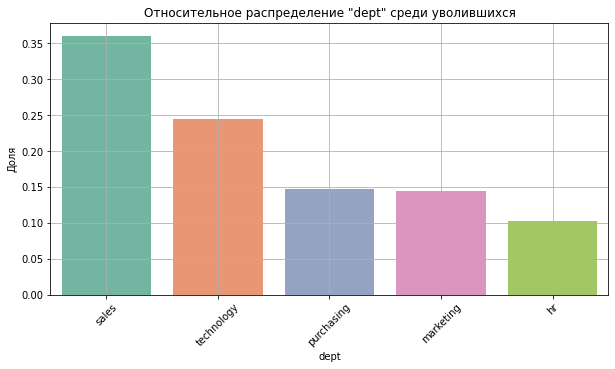

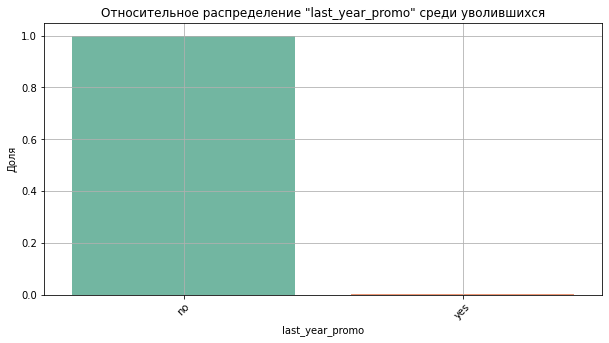

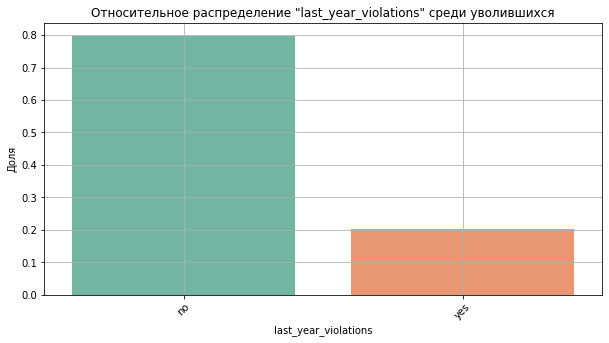

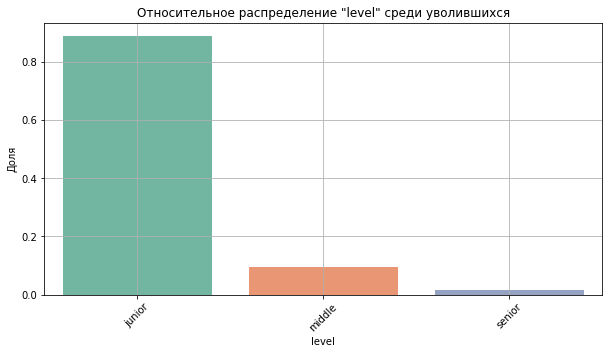

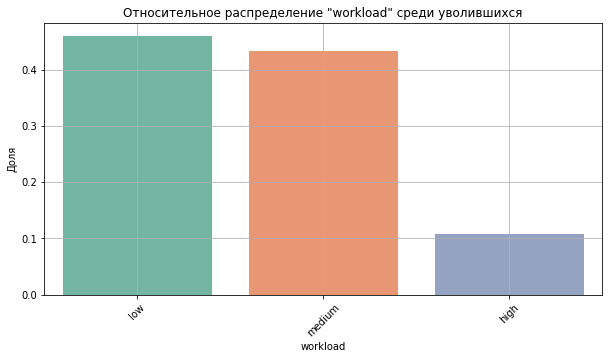

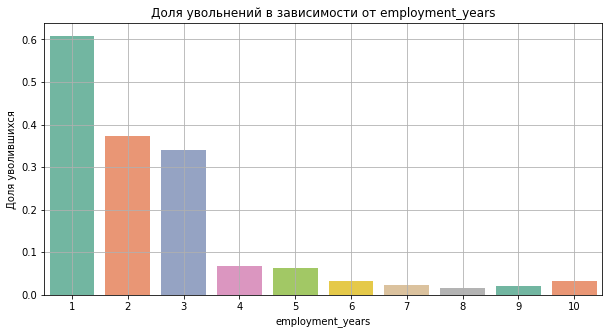

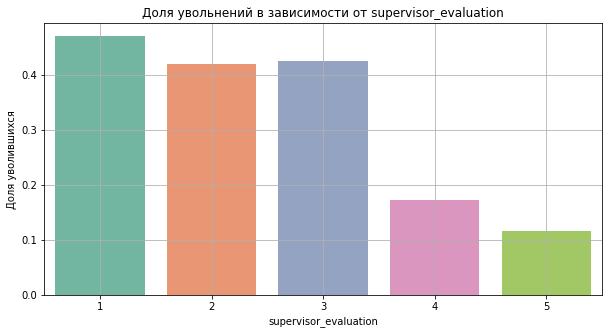

In [48]:
# определяем количественные и категориальные признаки
numerical_features = train_quit.select_dtypes(include=['int64', 'float64']).columns.difference(['id', 'employment_years', 'supervisor_evaluation'])
categorical_features = train_quit.select_dtypes(include=['object']).columns.difference(['quit'])
discrete_features = ['employment_years', 'supervisor_evaluation']

# нормированные гистограммы для количественных признаков
for column in numerical_features:
    sns.histplot(data=train_quit, x=column, hue="quit", stat='density', common_norm=False, bins=30, alpha=0.5)
    plt.title(f'Распределение признака "{column}" (нормировано)')
    plt.xlabel(column)
    plt.ylabel('Плотность')
    plt.grid()
    plt.show()

# относительные частоты для категориальных признаков
for column in categorical_features:
    cat_counts = train_quit[train_quit['quit'] == 'yes'][column].value_counts(normalize=True)
    sns.barplot(x=cat_counts.index, y=cat_counts.values, palette="Set2")
    plt.xlabel(column)
    plt.ylabel('Доля')
    plt.title(f'Относительное распределение "{column}" среди уволившихся')
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()
    
# относительные частоты для дискретных признаков
for feature in discrete_features:
    discrete_counts = train_quit.groupby(feature)['quit'].value_counts(normalize=True).unstack()
    if 'yes' in discrete_counts.columns:
        sns.barplot(x=discrete_counts.index, y=discrete_counts['yes'], palette="Set2")
        plt.title(f'Доля увольнений в зависимости от {feature}')
        plt.xlabel(feature)
        plt.ylabel('Доля уволившихся')
        plt.grid()
        plt.show()


Составим портрет "уволившегося сотрудника":
 - чаще всего увольняются новички, проработавшие не более 3 лет, а также тех, кто занимает позицию junior
 - если сотрудника повышали за последний год, вероятность его увольнения очень мала
 - среди отделов по увольнению отдел продаж
 - зарплата тоже очень влияет на факт увольнения
 - в части загруженности - как ни странно увольняются чаще сотрудники с низкой и средней загруженностью (видимо, скучно на работе :))

Объединим в одну таблицу оба целевых признака и проверим утверждение, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник

In [49]:
merged_data = test_target_job_satisfaction_rate.merge(test_target_quit, on='id', how='left')
merged_data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
 2   quit                   2000 non-null   object 
dtypes: float64(1), int64(1), object(1)
memory usage: 62.5+ KB


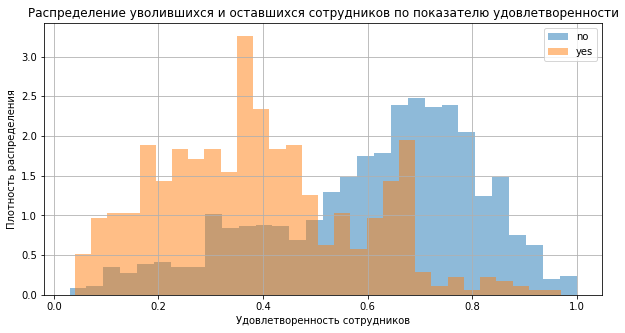

In [50]:
grouped_data = merged_data.groupby('quit')

for name, group in grouped_data:
    plt.hist(group['job_satisfaction_rate'], bins=30, alpha=0.5, label=name, density=True)

plt.title('Распределение уволившихся и оставшихся сотрудников по показателю удовлетворенности')
plt.xlabel('Удовлетворенность сотрудников')
plt.ylabel('Плотность распределения')
plt.legend()
plt.grid()
plt.show()


Из графика видим, что чаще всего увольняются сотрудники с меньшим показателем удовлетворенности, то есть можем сделать вывод, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник.

#### Промежуточный вывод
На данном этапе мы составили портрет "уволившегося сотрудника", а также подтвердили гипотезу, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник.

### Добавление нового входного признака
Добавим job_satisfaction_rate, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи.

In [51]:
test_features['job_satisfaction_rate'] = randomized_search.predict(test_features)
train_quit['job_satisfaction_rate'] = randomized_search.predict(train_quit)
train_quit.head()


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,no,0.63875
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.83600
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.34000
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.38000
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.69000


In [52]:
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800.0,0.844194
1,686555,hr,junior,medium,1,no,no,4,30000.0,0.682222
2,467458,sales,middle,low,5,no,no,4,19200.0,0.654000
3,418655,sales,middle,low,6,no,no,4,19200.0,0.666000
4,789145,hr,middle,medium,5,no,no,5,40800.0,0.792000


### Подготовка данных
Подготовим признаки так же, как и в первой задаче: выполним подготовку в пайплайне, дополнив пайплайн предобработки.

In [53]:
train_quit_without_id = train_quit.drop(['id'], axis=1)
print('Количество дубликатов в таблице train_quit_without_id:', train_quit_without_id.duplicated().sum())


Количество дубликатов в таблице train_quit_without_id: 1413


Удалим дубликаты, появившиеся после удаления id.

In [54]:
train_quit_without_id=train_quit_without_id.drop_duplicates()
train_quit_without_id.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2587 entries, 0 to 3998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   2587 non-null   object 
 1   level                  2587 non-null   object 
 2   workload               2587 non-null   object 
 3   employment_years       2587 non-null   int64  
 4   last_year_promo        2587 non-null   object 
 5   last_year_violations   2587 non-null   object 
 6   supervisor_evaluation  2587 non-null   int64  
 7   salary                 2587 non-null   int64  
 8   quit                   2587 non-null   object 
 9   job_satisfaction_rate  2587 non-null   float64
dtypes: float64(1), int64(3), object(6)
memory usage: 222.3+ KB


In [55]:
merged_test_quit = test_features.merge(test_target_quit, on='id', how='left')

In [56]:
X_train = train_quit_without_id.drop(['quit'], axis=1)
y_train = train_quit_without_id['quit']
X_test = merged_test_quit.drop(['id', 'quit'], axis=1)
y_test = merged_test_quit['quit']

In [57]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)


In [58]:
print(label_encoder.classes_) 

['no' 'yes']


In [59]:
# создаём списки с названиями признаков
ohe_columns = ['last_year_promo', 'last_year_violations', 'dept']
ord_columns = ['level', 'workload']

num_columns = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ]
    )

# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'],
                    ['low', 'medium', 'high'],
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

### Обучение модели

In [60]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]  
    },
    
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__C': range(1,5),
        'models__kernel': ['linear', 'rbf', 'sigmoid'], 
        'models__gamma': ['scale', 'auto'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]  
    }

]

In [61]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    n_iter=50,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке (при кроссвалидации):', randomized_search.best_score_)

# проверяем работу модели на тестовой выборке
# рассчитаем прогноз на тестовых данных
y_test_pred = randomized_search.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred[:,1])}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['last_year_promo',
                                                   'last_year_violations',
                                                   'dept']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImput

#### Промежуточный вывод
Лучше всего с поставленной задачей справилась модель SVC, целевой показатель (ROC-AUC≥0.91 на тестовой выборке) достигнут.

### Выводы к задаче 2
В этой задаче поработали с анализом ситуации с увольнением, "Нарисовали" портрет уволившегося сотрудника, а также предстказали вероятность увольнения каждого уволившегося.

## Итоговый вывод

В данном проекте проанализированы данные, предоставленные компанией «Работа с заботой», которая помогает бизнесу оптимизировать управление персоналом.

Проект был логически разделен на две задачи:
 - первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика
 - вторая — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.
 
В каждой из задач были выполнены такие этапы, как:
 - загрузка данных
 - предобработка данных
 - исследовательский анализ данных
 - подготовка данных
 - обучение моделей и выбор лучшей из них, а также предсказание целевого признака

На каждом из этапов сделан промежуточный вывод.

Почему указанные выше задачи так важны бизнесу: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.

По результатам проведенного исследования могут быть даны следующие предложения:
 - обратить особое внимание на адаптацию новых сотрудников в компании (так как большинство увольняющихся сотрудников проработали менее 3 лет)
 - обратить внимание на условия труда/оплаты и других факторов в отделе продаж - там текучка кадров наибольшая среди отделов.